Nama : Baihaqi Nur Muhammad

NPM : 24083010111

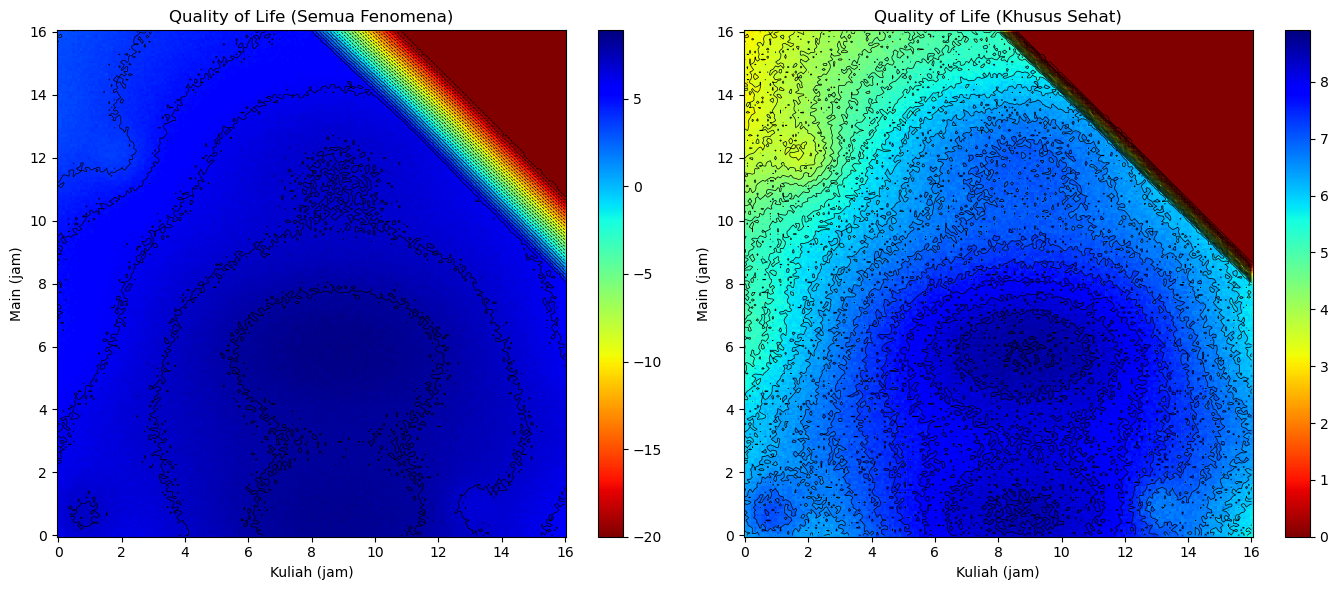

Titik Optimum Numerik:
- Kuliah: 9.69 jam
- Main:   4.64 jam
- QoL:    8.65

Jadwal Harian (berdasarkan optimum):
- 23:00 - 07:00  Tidur
- 07:00 - 07:30  Olahraga
- 07:30 - 17:12  Kuliah / Belajar
- 17:12 - 18:24  Waktu Bebas / Makan / Sosialisasi
- 18:24 - 23:00  Hiburan / Main


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

# ==============================
# 1) PARAMETER (bisa dimainkan)
# ==============================
istirahat = 8              # jam tidur
penalty_scale = 0.2        # penalti total jam
kebanyakan_main_scale = 1  # penalti kebanyakan main
kebanyakan_lembur_scale = 0.8  # penalti kebanyakan lembur
exercise_hours = 0.5       # olahraga (jam/hari)
sleep_quality = 0.9        # faktor kualitas tidur (0-1)

# ==============================
# Grid setup
# ==============================
xmin, xmax, ymin, ymax = 0, 24 - istirahat, 0, 24 - istirahat
res = 200
x = np.linspace(xmin, xmax, res)  # jam kuliah
y = np.linspace(ymin, ymax, res)  # jam main
X, Y = np.meshgrid(x, y)

# ==============================
# Preferensi
# ==============================
kuliah_pref = np.exp(-((X - 9.0) ** 2) / (10 ** 2))
main_pref   = np.exp(-((Y - 4.0) ** 2) / (10 ** 2))

# ==============================
# Penalti & faktor eksternal
# ==============================
total_waktu = X + Y
total_penalty = penalty_scale * np.exp(total_waktu / 24.0)

kebanyakan_main   = kebanyakan_main_scale * np.exp(-((X - 2.0) ** 2 + (Y - 12.0) ** 2) / 0.8)
kebanyakan_lembur = kebanyakan_lembur_scale * np.exp(-((X - 13.0) ** 2 + (Y - 1.0) ** 2) / 0.6)

# Ripple motivasi harian + noise
np.random.seed(111)
ripple = 0.4 * np.sin((0.3 * X) - 1) * np.cos(1.0 * Y) - 0.2
ripple += np.random.normal(loc=0.0, scale=0.1, size=X.shape)

# ==============================
# 2) Objective Function (QoL)
# ==============================
Z = 10.0 * (0.6 * kuliah_pref + 0.4 * main_pref)
Z = Z - kebanyakan_main - kebanyakan_lembur - total_penalty + ripple
Z -= 10.0 * np.maximum(total_waktu - 24.0, 0.0)

# Faktor tambahan
Z += 2.0 * np.exp(-((X - exercise_hours) ** 2 + (Y - exercise_hours) ** 2) / 2.0)  # olahraga
Z *= sleep_quality  # kualitas tidur

# ==============================
# 1a) Plot berdampingan
# ==============================
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Semua fenomena
Z_clip_all = np.clip(Z, -20, 20)
c1 = axs[0].pcolormesh(X, Y, Z_clip_all, cmap='jet_r', shading='auto')
axs[0].contour(X, Y, Z_clip_all, levels=30, colors='black', linewidths=0.5)
axs[0].set_title("Quality of Life (Semua Fenomena)")
axs[0].set_xlabel("Kuliah (jam)")
axs[0].set_ylabel("Main (jam)")
fig.colorbar(c1, ax=axs[0])

# Khusus sehat
Z_clip_sehat = np.clip(Z, 0, 10)
c2 = axs[1].pcolormesh(X, Y, Z_clip_sehat, cmap='jet_r', shading='auto')
axs[1].contour(X, Y, Z_clip_sehat, levels=30, colors='black', linewidths=0.5)
axs[1].set_title("Quality of Life (Khusus Sehat)")
axs[1].set_xlabel("Kuliah (jam)")
axs[1].set_ylabel("Main (jam)")
fig.colorbar(c2, ax=axs[1])

plt.tight_layout()
plt.show()

# ==============================
# 3) Optimisasi Numerik (tanpa np.argmax)
# ==============================
def objective(xy):
    xi, yi = xy
    if xi < xmin or xi > xmax or yi < ymin or yi > ymax:
        return -1e6
    i = np.argmin(np.abs(x - xi))
    j = np.argmin(np.abs(y - yi))
    return Z[j, i]

def hill_climb(start, step=0.5, max_iter=200):
    x0, y0 = start
    best_val = objective((x0, y0))
    for _ in range(max_iter):
        improved = False
        for dx, dy in [(step,0), (-step,0), (0,step), (0,-step)]:
            cand = (x0 + dx, y0 + dy)
            val = objective(cand)
            if val > best_val:
                x0, y0, best_val = cand[0], cand[1], val
                improved = True
        if not improved:
            step /= 2
        if step < 0.05:
            break
    return x0, y0, best_val

# Multi-start
np.random.seed(111)
best_x, best_y, best_val = None, None, -1e6
for _ in range(15):
    start = (np.random.uniform(xmin, xmax), np.random.uniform(ymin, ymax))
    cx, cy, cz = hill_climb(start)
    if cz > best_val:
        best_x, best_y, best_val = cx, cy, cz

print("Titik Optimum Numerik:")
print(f"- Kuliah: {best_x:.2f} jam")
print(f"- Main:   {best_y:.2f} jam")
print(f"- QoL:    {best_val:.2f}")

# ==============================
# 4) Cerita Aktivitas Harian
# ==============================
def buat_jadwal(start_time="07:00"):
    jam_tidur = istirahat
    jam_kuliah = round(best_x, 1)
    jam_main   = round(best_y, 1)
    jam_olahraga = exercise_hours
    total_aktivitas = jam_tidur + jam_kuliah + jam_main + jam_olahraga
    waktu_bebas = 24 - total_aktivitas

    start = dt.datetime.strptime(start_time, "%H:%M")
    jadwal = []

    def add_activity(start, durasi, nama):
        end = start + dt.timedelta(hours=durasi)
        jadwal.append(f"{start.strftime('%H:%M')} - {end.strftime('%H:%M')}  {nama}")
        return end

    # Urutan aktivitas
    t = start
    t = add_activity(t, jam_tidur, "Tidur")
    t = add_activity(t, jam_olahraga, "Olahraga")
    t = add_activity(t, jam_kuliah, "Kuliah / Belajar")
    if waktu_bebas > 0:
        t = add_activity(t, waktu_bebas, "Waktu Bebas / Makan / Sosialisasi")
    t = add_activity(t, jam_main, "Hiburan / Main")

    return jadwal

print("\nJadwal Harian (berdasarkan optimum):")
for kegiatan in buat_jadwal("23:00"):   # mulai tidur jam 23:00
    print("-", kegiatan)


# Gambar terdiri dari dua grafik kontur yang menggambarkan hubungan antara waktu kuliah (belajar) dan waktu hiburan/main terhadap Quality of Life (QoL) atau kualitas hidup.

Grafik Kiri: "Quality of Life (Semua Fenomena)"

Grafik ini mempertimbangkan semua faktor (tidur, belajar, hiburan, olahraga, dan lain-lain).

Warna biru menunjukkan QoL yang rendah, sedangkan warna merah/kuning menunjukkan QoL yang lebih tinggi.

Dari hasil perhitungan numerik, titik optimum ditemukan ketika:

Kuliah ≈ 9,69 jam per hari

Main ≈ 4,64 jam per hari

QoL (skor kualitas hidup) ≈ 8,65

Grafik Kanan: "Quality of Life (Khusus Sehat)"

Grafik ini lebih menekankan faktor kesehatan (tidur & olahraga cukup).

Titik optimum berbeda, dengan kecenderungan lebih banyak waktu hiburan/aktivitas fisik dan lebih sedikit kuliah dibanding grafik kiri.

Hal ini menunjukkan bahwa jika kesehatan jadi prioritas, porsi waktu untuk hiburan/aktivitas fisik lebih besar diperlukan agar kualitas hidup tetap tinggi.

# Interpretasi Jadwal Harian (berdasarkan optimum di grafik kiri)

Dari hasil optimasi, terbentuk jadwal harian yang seimbang:

23:00 – 07:00 → Tidur (8 jam)
→ Memberi cukup istirahat agar tubuh tetap sehat dan segar.

07:00 – 07:30 → Olahraga (30 menit)
→ Aktivitas fisik singkat untuk menjaga kesehatan tubuh.

07:30 – 17:12 → Kuliah / Belajar (± 9,5 jam)
→ Fokus utama pada perkuliahan dan akademik.

17:12 – 18:24 → Waktu Bebas / Makan / Sosialisasi (± 1 jam)
→ Untuk makan malam, istirahat sebentar, atau interaksi sosial ringan.

18:24 – 23:00 → Hiburan / Main (± 4,5 jam)
→ Waktu untuk refreshing, menonton, main game, atau bersosialisasi dengan teman.

# Kesimpulan

Keseimbangan waktu sangat penting. Terlalu banyak kuliah atau terlalu banyak main akan menurunkan kualitas hidup.

Hasil optimasi menunjukkan bahwa kualitas hidup terbaik dicapai dengan:

Tidur cukup (8 jam),

Belajar sekitar 9–10 jam,

Hiburan 4–5 jam,

Olahraga rutin walau singkat.

Jika fokus pada kesehatan, waktu hiburan/aktivitas fisik sebaiknya lebih banyak, meski waktu belajar sedikit berkurang.

Jadwal ini bisa menjadi panduan agar mahasiswa bisa produktif belajar tanpa mengorbankan kesehatan dan kebahagiaan pribadi.